# Identifiying Multivariate Outliers using Machine Learning Algorithms

### Introduction

Built by Alea Dorsey-Tyler leveraging [DataCamp's Anomaly Detection Course](https://www.datacamp.com/courses/anomaly-detection-in-python). It's highly recommended to read [Introduction to Anomaly Detection]( https://www.datacamp.com/tutorial/introduction-to-anomaly-detection) and [pyOD's Outlier Detection 101](https://pyod.readthedocs.io/en/latest/relevant_knowledge.html) before starting. 

This tool can be used during data preparation to identify anomalies that may be outliers. These potential outliers are identified based on a combined probability score produced by the multiple instances of the [Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest), [K Nearest Neighbor (KNN)](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#k-NN_outlier), and [Local Outlier Factor (LOF)](https://en.wikipedia.org/wiki/Local_outlier_factor) statistical models.  

### Downloading Libraries

To begin, ensure you have the necessary libraries installed and loaded. This tool relies primarily on the [PyOD library](https://pyod.readthedocs.io/en/latest/index.html) and [Scikit-Learn](https://scikit-learn.org/stable/index.html), but we've also included [StatsModels Seasonal_Decompose](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) which can check the dataset for seasonality.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import QuantileTransformer

from statsmodels.tsa.seasonal import seasonal_decompose

from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.lof import LOF

In [13]:
############################################
# INCLUDES
############################################
#libraries specific to this example
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.linear_model import LinearRegression
import matplotlib as matplt
import matplotlib.pyplot as plt

#a set of libraries that perhaps should always be in Python source
import os 
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings

#a darn useful library for creating paths and one I recommend you load to your environment
from pathlib import Path

#Import a custom library, in this case a fairly useful logging framework
if os.environ.get('LIB_LOCATION') is not None:
    debug_lib_location = Path(os.getenv('LIB_LOCATION'))
else:
    debug_lib_location = Path("./")
                              
if os.environ.get('DATA_LOCATION') is not None:
    root_location = os.getenv('DATA_LOCATION')
else:
    root_location="." + os.sep + "data";                              

sys.path.append(str(debug_lib_location))
import debug

### Pandas / Numpy Format Management

In [15]:
############################################
#JUPYTER NOTEBOOK OUTPUT CONTROL / FORMATTING
############################################
#pandas set floating point to 4 places to things don't run loose
pd.options.display.float_format = '{:,.4f}'.format
np.set_printoptions(precision=4)

### Know Library Versions

In [16]:
def lib_diagnostics():
    debug.msg_debug("System version    #:{:>12}".format(sys.version))
    debug.msg_debug("Matplotlib version#:{:>12}".format(matplt.__version__))
    debug.msg_debug("Numpy version     #:{:>12}".format(np.__version__))
    debug.msg_debug("Pandas version    #:{:>12}".format(pd.__version__))
    debug.msg_debug("SciPy version     #:{:>12}".format(sp.__version__))

    return

In [17]:
lib_diagnostics()

[2024-05-15 21:39:37 UTC]   DEBUG: System version    #:3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:49:32) 
[GCC 12.3.0] 
[2024-05-15 21:39:37 UTC]   DEBUG: Matplotlib version#:       3.8.1 
[2024-05-15 21:39:37 UTC]   DEBUG: Numpy version     #:      1.24.3 
[2024-05-15 21:39:37 UTC]   DEBUG: Pandas version    #:       2.1.2 
[2024-05-15 21:39:37 UTC]   DEBUG: SciPy version     #:      1.11.3 


### Identifying the Source Data

In the following code block, import your data into a dataframe. If implementing this tool into an existing process, note that this tool will be converting datatypes and scaling all numeric variables to a normal distribution. It's advised to make a copy of the dataframe solely for the identification of anomalies so that further analysis can be done on their properties, source, etc.

In [18]:
# Importing from a file
#path = r'C:\Users\AleaDorseyTyler\OneDrive - USDA\Desktop\Alea Detail\CIO Detail\Prompt Injection\Data Sources\VENICE_VIIRS_PICKLE_VENICE_VIIRS_2.csv'
#df = pd.read_csv(path, parse_dates=["Datetime"], index_col = "Index")

#READ DATA IN
the_filename = "/projects/data/intro_data/MULTIVARIATE/ISIIS_1_BigCam_TT_5JUL23.csv"
the_delimiter= ","
#filename = os.path.join(root_location, "mooring_data.txt")

if os.path.isfile(the_filename):
    try:
        df=pd.read_csv(the_filename, delimiter=the_delimiter, engine='python')
        df_anom = df.copy()
    except OSError as e:
        debug.msg_error(f"Exception found: {e}")
        debug.msg_error(f"Unable to filename ({fname}) in code at {__name__}.{inspect.stack()[0][3]}.")  #note fname provided by Exception OSError
        debug.msg_error("Please check your paths and restart.")   
else:
    debug.msg_error(f"Unable to filename ({the_filename}) in code at {__name__}.{inspect.stack()[0][3]}.")
    debug.msg_error("Please check your paths and restart.")


### Know Your DataSet

In [19]:
df

,Time,Pres(dbar),Temp(C),Cond(S/m),Sal(PSU),c399.3,c402.8,c406.2,c409.8,c413.2,...,Chla435nm,Chlbc454nm,Chlb469nm,PPC492nm,PSC523nm,Chlc585nm,Chla617nm,Chlc639nm,Chla661nm,Chla675nm
0,28-Apr-2018 01:02:29.696,1.1710,9.8797,3.5408,32.3758,1.5288,1.4982,1.4640,1.4241,1.3887,...,0.0066,0.0006,0.0012,0.0058,0.0004,0.0000,0.0000,0.0005,0.0003,0.0104
1,28-Apr-2018 01:02:29.821,1.1559,9.8791,3.5408,32.3769,1.5838,1.5598,1.5046,1.4800,1.4469,...,0.0066,0.0006,0.0012,0.0058,0.0004,0.0000,0.0000,0.0005,0.0003,0.0104
2,28-Apr-2018 01:02:29.940,1.1683,9.8775,3.5407,32.3766,1.5596,1.5390,1.4889,1.4558,1.4211,...,0.0066,0.0006,0.0012,0.0058,0.0004,0.0000,0.0000,0.0005,0.0003,0.0104
3,28-Apr-2018 01:02:30.047,1.1796,9.8768,3.5406,32.3762,1.5299,1.5094,1.4670,1.4235,1.3878,...,0.0066,0.0006,0.0012,0.0058,0.0004,0.0000,0.0000,0.0005,0.0003,0.0104
4,28-Apr-2018 01:02:30.158,1.1781,9.8770,3.5406,32.3764,1.5277,1.5061,1.4638,1.4187,1.3836,...,0.0066,0.0006,0.0012,0.0058,0.0004,0.0000,0.0000,0.0005,0.0003,0.0104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235574,28-Apr-2018 08:43:18.959,0.9225,9.6446,3.5920,33.1121,1.0068,0.9760,0.9396,0.9036,0.8712,...,0.0067,0.0008,0.0014,0.0087,0.0004,0.0000,0.0000,0.0008,0.0003,0.0158
235575,28-Apr-2018 08:43:19.086,0.9477,9.6443,3.5919,33.1119,1.0078,0.9759,0.9441,0.9034,0.8757,...,0.0067,0.0008,0.0014,0.0087,0.0004,0.0000,0.0000,0.0008,0.0003,0.0158
235576,28-Apr-2018 08:43:19.193,0.9580,9.6439,3.5919,33.1119,1.0032,0.9794,0.9457,0.9089,0.8784,...,0.0067,0.0008,0.0014,0.0087,0.0004,0.0000,0.0000,0.0008,0.0003,0.0159
235577,28-Apr-2018 08:43:19.308,0.9755,9.6435,3.5918,33.1117,1.0039,0.9787,0.9466,0.9096,0.8792,...,0.0067,0.0008,0.0014,0.0087,0.0004,0.0000,0.0000,0.0008,0.0003,0.0159


### Head

In [23]:
#Display the first few rows of the dataset
df.head()

,Time,Pres(dbar),Temp(C),Cond(S/m),Sal(PSU),c399.3,c402.8,c406.2,c409.8,c413.2,...,Chla435nm,Chlbc454nm,Chlb469nm,PPC492nm,PSC523nm,Chlc585nm,Chla617nm,Chlc639nm,Chla661nm,Chla675nm
0,28-Apr-2018 01:02:29.696,1.1710,9.8797,3.5408,32.3758,1.5288,1.4982,1.4640,1.4241,1.3887,...,0.0066,0.0006,0.0012,0.0058,0.0004,0.0000,0.0000,0.0005,0.0003,0.0104
1,28-Apr-2018 01:02:29.821,1.1559,9.8791,3.5408,32.3769,1.5838,1.5598,1.5046,1.4800,1.4469,...,0.0066,0.0006,0.0012,0.0058,0.0004,0.0000,0.0000,0.0005,0.0003,0.0104
2,28-Apr-2018 01:02:29.940,1.1683,9.8775,3.5407,32.3766,1.5596,1.5390,1.4889,1.4558,1.4211,...,0.0066,0.0006,0.0012,0.0058,0.0004,0.0000,0.0000,0.0005,0.0003,0.0104
3,28-Apr-2018 01:02:30.047,1.1796,9.8768,3.5406,32.3762,1.5299,1.5094,1.4670,1.4235,1.3878,...,0.0066,0.0006,0.0012,0.0058,0.0004,0.0000,0.0000,0.0005,0.0003,0.0104
4,28-Apr-2018 01:02:30.158,1.1781,9.8770,3.5406,32.3764,1.5277,1.5061,1.4638,1.4187,1.3836,...,0.0066,0.0006,0.0012,0.0058,0.0004,0.0000,0.0000,0.0005,0.0003,0.0104


### Describe

In [22]:
#Summary statistics
df.describe()

,Pres(dbar),Temp(C),Cond(S/m),Sal(PSU),c399.3,c402.8,c406.2,c409.8,c413.2,c416.7,...,Chla435nm,Chlbc454nm,Chlb469nm,PPC492nm,PSC523nm,Chlc585nm,Chla617nm,Chlc639nm,Chla661nm,Chla675nm
count,"235,579.0000","235,579.0000","235,579.0000","235,579.0000","235,579.0000","235,579.0000","235,579.0000","235,579.0000","235,579.0000","235,579.0000",...,"235,579.0000","235,579.0000","235,579.0000","235,579.0000","235,579.0000","235,579.0000","235,579.0000","235,579.0000","235,579.0000","235,579.0000"
mean,22.4083,8.1263,3.4437,32.9692,1.3134,1.2819,1.2420,1.2050,1.1685,1.1311,...,0.0056,0.0005,0.0010,0.0059,0.0003,0.0000,0.0000,0.0011,0.0005,0.0163
std,13.8985,0.7364,0.0577,0.2900,0.2869,0.2851,0.2841,0.2821,0.2796,0.2788,...,0.0014,0.0002,0.0004,0.0015,0.0002,0.0000,0.0001,0.0005,0.0002,0.0060
min,0.6981,7.0932,3.3565,32.3081,0.8247,0.8003,0.7632,0.7315,0.7005,0.6671,...,0.0013,0.0001,0.0002,0.0021,0.0000,0.0000,0.0000,0.0000,0.0000,0.0069
25%,10.8045,7.5637,3.3978,32.7396,0.9903,0.9604,0.9218,0.8871,0.8536,0.8173,...,0.0047,0.0004,0.0008,0.0049,0.0002,0.0000,0.0000,0.0008,0.0003,0.0118
50%,20.9710,7.7136,3.4200,32.9549,1.4080,1.3757,1.3356,1.2977,1.2604,1.2226,...,0.0053,0.0005,0.0010,0.0058,0.0002,0.0000,0.0000,0.0010,0.0004,0.0145
75%,32.3486,8.7478,3.4898,33.2013,1.5413,1.5083,1.4677,1.4288,1.3904,1.3526,...,0.0064,0.0006,0.0011,0.0066,0.0003,0.0000,0.0000,0.0014,0.0006,0.0206
max,60.6588,9.9833,3.6009,33.6317,2.0715,2.0586,2.0197,1.9723,1.9296,1.8888,...,0.0193,0.0031,0.0046,0.0157,0.0032,0.0001,0.0035,0.0045,0.0033,0.0550


### Column Names

In [40]:
print(df.columns.values)

['Time' 'Pres(dbar)' 'Temp(C)' 'Cond(S/m)' 'Sal(PSU)' 'c399.3' 'c402.8'
 'c406.2' 'c409.8' 'c413.2' 'c416.7' 'c421.0' 'c425.1' 'c429.3' 'c433.3'
 'c437.1' 'c441.2' 'c445.6' 'c450.2' 'c454.8' 'c458.9' 'c462.9' 'c467.3'
 'c472.0' 'c476.8' 'c481.3' 'c486.0' 'c490.4' 'c494.6' 'c498.9' 'c503.5'
 'c508.0' 'c512.8' 'c517.7' 'c522.5' 'c526.8' 'c531.1' 'c535.4' 'c539.7'
 'c544.0' 'c548.5' 'c552.9' 'c557.4' 'c561.6' 'c566.1' 'c570.2' 'c574.1'
 'c578.1' 'c581.9' 'c586.8' 'c591.0' 'c595.5' 'c600.1' 'c604.8' 'c609.2'
 'c613.9' 'c618.2' 'c622.9' 'c627.0' 'c631.4' 'c635.8' 'c640.0' 'c644.5'
 'c648.8' 'c653.2' 'c657.8' 'c662.3' 'c666.8' 'c671.1' 'c675.7' 'c679.9'
 'c684.2' 'c688.4' 'c692.4' 'c696.5' 'c700.5' 'c704.4' 'c708.4' 'c712.3'
 'c716.1' 'c720.1' 'c723.8' 'c727.5' 'c731.3' 'c735.0' 'c738.3' 'c741.9'
 'a398.2' 'a401.8' 'a405.1' 'a408.9' 'a412.1' 'a415.5' 'a419.2' 'a423.5'
 'a427.6' 'a431.7' 'a435.4' 'a439.1' 'a443.3' 'a447.8' 'a452.2' 'a456.6'
 'a460.4' 'a464.7' 'a469.0' 'a473.8' 'a478.3' 'a483.

### Information About the DataFrame

In [41]:
#Information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235579 entries, 0 to 235578
Columns: 224 entries, Time to Chla675nm
dtypes: float64(222), int64(1), object(1)
memory usage: 402.6+ MB
None


### Poor Outlier Check

In [27]:
#Using median calculations and IQR, outliers are identified and these data points should be removed
#maybe loop through all df.columns and perform this calculation.

"""
Q1 = df["column_name"].quantile(0.25)
Q3 = df["column_name"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[df["column_name"].between(lower_bound, upper_bound)]
"""

'\nQ1 = df["column_name"].quantile(0.25)\nQ3 = df["column_name"].quantile(0.75)\nIQR = Q3 - Q1\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\ndf = df[df["column_name"].between(lower_bound, upper_bound)]\n'

### Identify Unique Columns that require Management

In [73]:
field_datetime="Time"
#field_target="Temp(C)"
field_target="copepod"

### Preprocessing the Dataset

This section will use skikit's [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) and [QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) to prepare the data for anomaly detection.

OrdinalEncoder will assign categories to a number (0 to n-1). Like Scikit, [pyOD needs all values to be numerical](https://github.com/yzhao062/pyod/issues/366).

Use the first code block to prepare your data for scaling. How much preparation is required will vary, but here are some recommended best practices:
- All categorical fields are numerically encoded 
- All date-time fields have additional 'day_of_week', 'month', 'day' decompositions added so variation such as seasonality is easier to identify.

In [74]:
###################################### Check data types, make any conversions necessary
df_anom.dtypes

#convert appropriate fields to appropriate types, inpsect your column output.
df_anom[field_datetime] = pd.to_datetime(df[field_datetime])
###################################### Break out date fields
## IMPORTANT! Treat these fields as ordinal categorical, do not scale in the next step
df_anom['day_of_week'] = df_anom[field_datetime].dt.day_of_week

df_anom['month'] = df_anom[field_datetime].dt.month

df_anom['day'] = df_anom[field_datetime].dt.day

###################################### Encode categorical variables, including date fields
# Initialize the encoder
oe = OrdinalEncoder()

# Extract the categorical feature names
cats = df_anom.select_dtypes(include= ["category","datetime"]).columns.tolist()

# Encode the categorical features
cats_encoded = oe.fit_transform(df_anom[cats])

# Replace the old values with encoded values
df_anom.loc[:, cats] = cats_encoded


Now identify the columns that need to be scaled. Depending on your dataset it might be easier to select by datatype, hardcode via those included, or hardcode via those not included. QuantileTransformer will apply a non-linear transformation on the selected columns. Each feature will be mapped to a Gaussian (normal) distribution. This is important for increasing anomaly detection accuracy in proximity-based algorithms like KNN and LOF especially, because they ensure that instances compared to each other are at the same scale. 

<span style="color:orange">Note:</span><br/>
While these recommendations may improve the accuracy of anomaly detection in most cases, you are the expert of your own data. Compare results when more or fewer numeric fields are scaled.

In [75]:
###################################### Selected by datatype
to_scale = df_anom.select_dtypes(include="float").columns.tolist()
#print(to_scale)

###################################### Hardcoded by those included/not included
#to_scale = []

# Additional cleanup as needed
to_scale = to_scale[2:]
#print(to_scale)


Finally, we'll run QuantileTransformer to scale these columns

In [76]:
# Initiate the transformer
qt = QuantileTransformer(output_distribution = "normal")

# Scale the columns and replace the columns in the original
df_anom.loc[:,to_scale] = qt.fit_transform(df_anom[to_scale])

#df_anom.head

### <span style="color:orange">[Optional]</span> Analyzing Data for Seasonality & Running Univariate Detection on Residuals

If you have a datetime field, you can run [Seasonal Decompose](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) to get an idea how much your predicted variable is impacted by seasonality. This works best if the datetime field is set to the index, but is compatible without.

In [77]:
# Identify Y variable and period
target_col_name = field_target
target = df_anom[target_col_name]
period = 365 

# Run the decomposition
results = seasonal_decompose(target, period = period)

The next codeblock will print out the results of the model, including the original variation over time, the [seasonality, trend, and residuals](https://towardsdatascience.com/time-series-diy-seasonal-decomposition-f0b469afed44).

- **Seasonality** refers to the variation in the variable that correspond with patterns in time.
- **Trend** refers to the general variation in the variable over time, it's a rolling average of many data points 
- **Residual** refers to variation in the variable that can't be attributed to the trend or seasonality. 

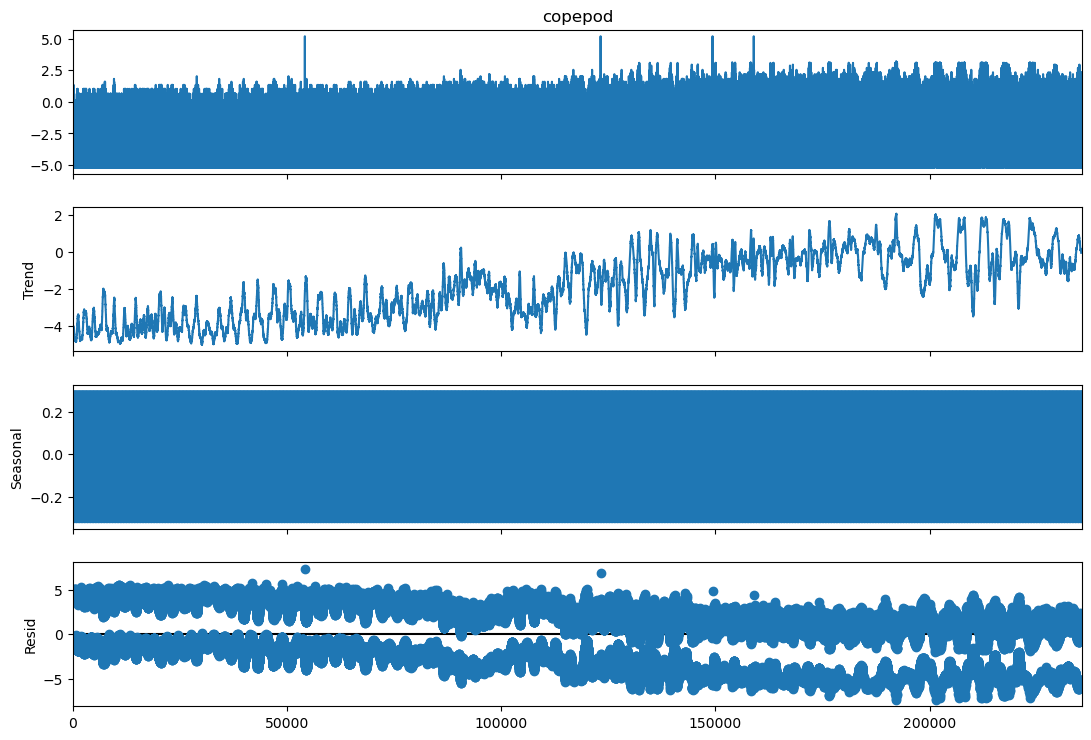

In [78]:
# plot the seasonality, trend, and residuals

fig = results.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
plt.show()

One method of outlier detection by fitting the residuals using the [Mean Absolute Deviation (MAD)](https://www.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/other-measures-of-spread/a/mean-absolute-deviation-mad-review) measure of variability, a univariate [i.e. only looks at one variable] way of identifying outliers. 

Running a MAD fit on a variable based on the residuals can help make inferences on what might be outliers, though it tends to overcorrect. Overall, it's best to use this methodlogy when conducting exploratory analysis and to provide context for other anomaly detection results, such as when estimating contamination.

In [55]:
from pyod.models.mad import MAD

# Pull and reshape the residuals
residuals = results.resid
residuals = residuals.values.reshape(-1,1) 

#fit a variable to the residuals using MAD
mad = MAD().fit(residuals)

# Like all pyOD models, once fit you can ask MAD to predict outliers using labels_
# Make a boolean for outliers MAD predicted
is_outlier = mad.labels_ == 1

# Pull predicted outliers from the dataframe 
outliers = df_anom[is_outlier]

# How many outliers did this method find?
print("Number of outliers found using MAD to fit variable", target_col_name, "on residuals:", len(outliers))

Number of outliers found using MAD to fit variable Temp(C) on residuals: 31937


### Identifying Anomalies Using Multiple Models

#### Selecting Hyperparameters

In order to effectively use this tool, it's imperative have a surface-level understanding of how each anomaly detection model works. This includes how it determines anomaly probability, what hyperparameters are available to tune the model, and what to consider when tuning those values.

**<span style="color:orange">Across Models: Probability Threshold</span>**

Perhaps the simplest hyperparamater to understand is the probability threshold: according to your modelset, how likely is it that this observation is an outlier? This is going to depend on your use case, with some industries flagging anything above 50% and others - like the financial and medical fields - going as high as 90%. The best way to determine the appropriate threshold is to balance the cost of leaving outliers in versus the risk in taking them out. Having too many outliers in your data can hinder model results, but overculling datasets might make the model miss out on key insights.

When in doubt, it's recommended to begin at the default value (75%) and rerun the test at higher and lower thresholds. You can even create a variation on an [efficient frontier](https://en.wikipedia.org/wiki/Efficient_frontier) to help your stakeholders understand the options.

This parameter is applied after all models are run, and thus only has to be set once.

In [56]:
#Set the probability threshold
probability_threshold = .75

**<span style="color:orange">All Models: Contamination & n_jobs</span>**

Contamination refers to the amount of outliers in a dataset. Which is mighty *unhandy* as a hyperparameter in a model meant to tell us how many outliers are in our dataset. In addition to trial and error, there are some ways to make more-informed guesses. Univariate anomaly detection (such as the MAD we ran on a variable's residuals) tends to overcount anomalies as it cannot contextualize column-level variation with patterns throughout the dataset. This makes it a relatively ok tool to get a general idea of what the maximum number of anomalies may be. Running a few univariate tests and dividing the results by the nrows in a dataset is a good way to create an estimated upper bound of contamination.

The default contamination setting for pyOD models is 10%, but that doesn't mean it's applicable to all [or most] use cases. When in doubt, this is a hyperparameter that can be experimented with; have your final estimator list include models set to different contamination levels between .001 and roughly the max estimated from your univariate analysis.

n_jobs refers to the number of jobs being run concurrently. It's recommended to set this to -1 for all models so the number of jobs running parallel is equal to the number of cores available.

**<span style="color:orange">Isolation Forest: n_estimators, max_features, & max_samples</span>**

[Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest) uses binary decision trees to add random 'slices' to the dataset, counting how many slices it takes for a value to be completely isolated from the rest of the sample. It works on the concerpt that anomalous data points tend to be outside the clusters of datapoints, and thus take fewer slices to isolate.

In addition to contamination, you have the option of tuning how many base estimators, features, and samples the IForest model trains on. You can read about these hyperparameters [here](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest). It may seen like maximising the estimators, samples, and features would make the most reobust model, but that runs a major risk of overfitting. 

When in doubt, set multiple IForest models with some combinations of n_estimators varying from a center of 100, and max_samples and max_features <= 1.0,

**<span style="color:orange">K Nearest Neighbor and Local Outlier Factor: </span>** 

[KNN](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn) compares a datapoint's distance from its nearest neighbors. It works on the assumption that points far away from all their neighbors tend to be outliers. Perhaps the most important hyperparameters to consider are n_neighbors and method. n_neighbors refers to the number of neighbors the datapoint is compared to. Method decides how the distance is recorded; either the largest distance found (default), the mean of all distances, or the median of all distances.

[LOF](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.lof) builds on KNN to compared the local density of a value to the local density of its neighbors. Samples that have significantly lower density than their neighbors are given a highter Local Outlier Factor Score. Of the hyperparamters listed, it's fine to keep most default except n_neighbors.

When in doubt, have multiple instances of each model, with a mix of methods and n_neighbors set in variations between 5 and 20.

#### Setting the Models

In the code block below, experiment with the number of models and hyperparameter settings. Remember that too many models running may lead to overfitting and computation issues.

In [57]:
anom_estimators = [
    KNN(n_neighbors = 5, method = 'median', n_jobs = -1), 
    #KNN(n_neighbors = 15, method = 'mean', n_jobs = -1),
    KNN(n_jobs = -1),
    LOF(n_neighbors = 20, n_jobs = -1), 
    LOF(n_neighbors = 15, n_jobs = -1), 
    IForest(n_estimators= 50, n_jobs = -1), 
    #IForest(max_samples = .8, max_features = .8, n_jobs = -1),
    IForest(n_estimators = 200, n_jobs= -1)
    ]

#### Running the Models and Recording Results

Once you've chosen the models and hyperparameters they're set at, the rest of the code will run and record the estimated probabilities and return a list of predicted outliers. As with all models, there is an element of randomness that comes to play in the final results - it's always best practices to run the process a few time to get a sense of min-max predictions.

In [58]:
# Create an array to store the outlier probabilities
shape = (len(df_anom), len(anom_estimators))
probability_scores = np.empty(shape = shape)

# Run each model for each row, record the estimated probability the row is an outlier
for index, est in enumerate(anom_estimators):
    est.fit(df_anom)
    probs = est.predict_proba(df_anom)
    probability_scores [:, index] = probs[:,1]

# Calulate the mean estimated probability and add it to the dataframe
## NOTE: Can also use median
mean_scores = np.mean(probability_scores, axis = 1)
df_anom['mean_outlier_score'] = mean_scores

#Create a filter based on your stated confidence level
is_outlier = mean_scores > probability_threshold
outliers = df_anom[is_outlier]


/projects/app/anaconda/envs/machine_learning_gpu/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
/projects/app/anaconda/envs/machine_learning_gpu/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [62]:
#Print the results in a statement
print(len(outliers), "anomalies were detected using", len(anom_estimators),"models at", probability_threshold, "confidence")

0 anomalies were detected using 6 models at 0.75 confidence


You can then print out the list of anomalies, with the final column being the value's mean outlier score:

In [65]:
print(outliers)

Empty DataFrame
Columns: [Time, Pres(dbar), Temp(C), Cond(S/m), Sal(PSU), c399.3, c402.8, c406.2, c409.8, c413.2, c416.7, c421.0, c425.1, c429.3, c433.3, c437.1, c441.2, c445.6, c450.2, c454.8, c458.9, c462.9, c467.3, c472.0, c476.8, c481.3, c486.0, c490.4, c494.6, c498.9, c503.5, c508.0, c512.8, c517.7, c522.5, c526.8, c531.1, c535.4, c539.7, c544.0, c548.5, c552.9, c557.4, c561.6, c566.1, c570.2, c574.1, c578.1, c581.9, c586.8, c591.0, c595.5, c600.1, c604.8, c609.2, c613.9, c618.2, c622.9, c627.0, c631.4, c635.8, c640.0, c644.5, c648.8, c653.2, c657.8, c662.3, c666.8, c671.1, c675.7, c679.9, c684.2, c688.4, c692.4, c696.5, c700.5, c704.4, c708.4, c712.3, c716.1, c720.1, c723.8, c727.5, c731.3, c735.0, c738.3, c741.9, a398.2, a401.8, a405.1, a408.9, a412.1, a415.5, a419.2, a423.5, a427.6, a431.7, a435.4, a439.1, a443.3, ...]
Index: []


You can also investigate the results of each individual model:

In [66]:
#Take the data made in the for loop
df_scores = pd.DataFrame(probability_scores)

#calculate mean
df_scores['mean_score'] = df_scores.mean(axis=1)

#filter by confidence threshold
is_outlier2 = df_scores['mean_score'] > probability_threshold

#print filtered version
print(df_scores[is_outlier2])

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, mean_score]
Index: []


### Scaling vs. Normalization: What's the difference?


One of the reasons that it's easy to get confused between scaling and normalization is because the terms are ssometimes used interchangeably and, to make it even more confusing, they are very similar! In both cases, you're transforming the values of numeric variables so that the transformed data points have specific helpful properties:+ sn scaling, you're changing the range of your data, wh
  i+ 
in normalization, you're changing the shape of the distribution of your dions.

### Scaling

This means that you're transforming your data so that it fits within a specific scale, like 0-100 or 0-1. You want to scale data when you're using methods based on measures of how far apart data points are, like support vector machines (SVM) or k-nearest neighbors (KNN). With these algorithms, a change of "1" in any numeric feature is given the same importance.

For example, you might be looking at the prices of some products in both Yen and US Dollars. One US Dollar is worth about 100 Yen, but if you don't scale your prices, methods like SVM or KNN will consider a difference in price of 1 Yen as important as a difference of 1 US Dollar! This clearly doesn't fit with our intuitions of the world. With currency, you can convert between currencies. But what about if you're looking at something like height and weight? It's not entirely clear how many pounds should equal one inch (or how many kilograms should equal one meter).

By scaling your variables, you can help compare different variables on equal footing. 

In [69]:
!pip install mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 41.0 MB/s eta 0:00:0000:01
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


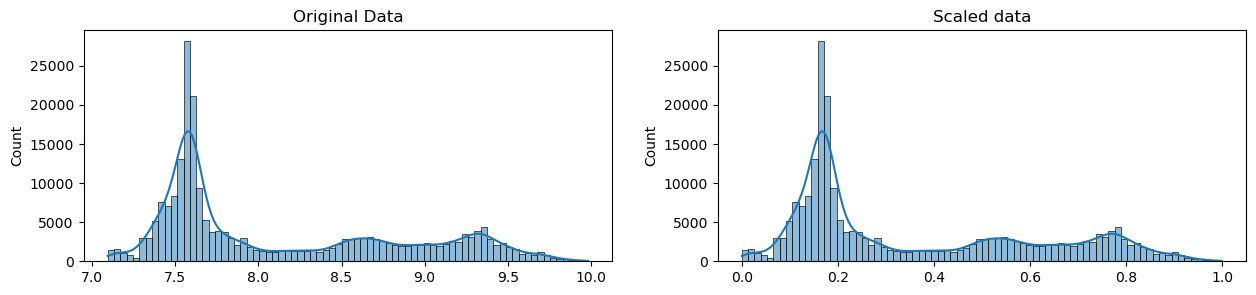

In [71]:
# modules we'll use
import pandas as pd
import numpy as np

# for Box-Cox Transformation
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

# set seed for repr

# generate 1000 data points randomly drawn from an exponential distribution
original_data = df[field_target].values

# mix-max scale the data between 0 and 1
scaled_data = minmax_scaling(original_data, columns=[0])

# plot both together to compare
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(scaled_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Scaled data")
plt.show()

### Normalization

Scaling just changes the range of your data. Normalization is a more radical transformation. The point of normalization is to change your observations so that they can be described as a normal distribution.

Normal distribution: Also known as the "bell curve", this is a specific statistical distribution where a roughly equal observations fall above and below the mean, the mean and the median are the same, and there are more observations closer to the mean. The normal distribution is also known as the Gaussian distribution.

In general, you'll normalize your data if you're going to be using a machine learning or statistics technique that assumes your data is normally distributed. Some examples of these include linear discriminant analysis (LDA) and Gaussian naive Bayes. (Pro tip: any method with "Gaussian" in the name probably assumes normality.)

The method we're using to normalize here is called the Box-Cox Transformation. Let's take a quick peek at what normalizing some data looks like:

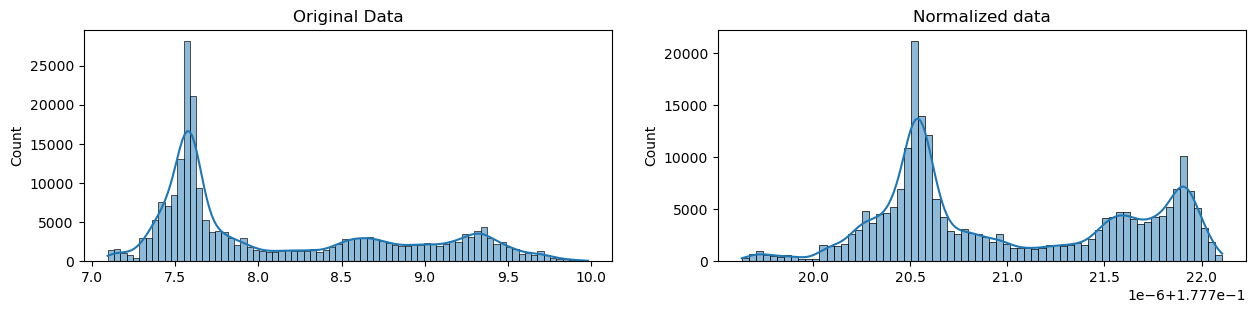

In [72]:
# normalize the exponential data with boxcox
normalized_data = stats.boxcox(original_data)

# plot both together to compare
fig, ax=plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(normalized_data[0], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Normalized data")
plt.show()

### String Encoding

In [7]:
# helpful character encoding module
import charset_normalizer

In [8]:
# start with a string
before = "This is the euro symbol: €"

# encode it to a different encoding, replacing characters that raise errors
after = before.encode("ascii", errors = "replace")

# convert it back to utf-8
print(after.decode("ascii"))

# We've lost the original underlying byte string! It's been 
# replaced with the underlying byte string for the unknown character :(

This is the euro symbol: ?


In [ ]:
# look at the first ten thousand bytes to guess the character encoding
with open("../input/kickstarter-projects/ks-projects-201801.csv", 'rb') as rawdata:
    result = charset_normalizer.detect(rawdata.read(10000))

# check what the character encoding might be
print(result)

In [ ]:
# read in the file with the encoding detected by charset_normalizer
kickstarter_2016 = pd.read_csv("../input/kickstarter-projects/ks-projects-201612.csv", encoding='Windows-1252')

# look at the first few lines
kickstarter_2016.head()

# Clean Up Some Data

In [ ]:
print(df.isnull())
print(df.isnull().sum())

# Exploring the Pandas .dropna() method
df.dropna(
    axis=0,         # Whether to drop rows or columns
    how='any',      # Whether to drop records if 'all' or 'any' records are missing
    thresh=None,    # How many columns/rows must be missing to drop
    subset=None,    # Which rows/columns to consider
    inplace=False   # Whether to drop in place (i.e., without needing to re-assign)
)

# Dropping Records Only if All Records are Missing
df = df.dropna(how='all')
print(df)

# Using .fillna() to Fill Missing Data
df = df.fillna(0)
print(df)
#filling NA with discrete values
df = df.fillna({'Name': 'Someone', 'Age': 25, 'Location': 'USA'})
print(df)
#OR
# Imputing a Missing Value
df['Age'] = df['Age'].fillna(df['Age'].mean())
print(df)

#duplicated data
print(df.duplicated().sum())
# The Pandas .drop_duplicates() method
df.drop_duplicates(
    subset=None,            # Which columns to consider 
    keep='first',           # Which duplicate record to keep
    inplace=False,          # Whether to drop in place
    ignore_index=False      # Whether to relabel the index
)
# Dropping Based on a Subset of Columns
df = df.sort_values(by='Date Modified', ascending=False)
df = df.drop_duplicates(subset=['Name', 'Age'], keep='first')
print(df)

# Trimming Whitespace from a Pandas Column
df['Favorite Color'] = df['Favorite Color'].str.strip()
print(df)
# Splitting a Column into Two Columns
df[['Last Name', 'First Name']] = df['Name'].str.split(',', expand=True)
# Replacing a Substring in Pandas
df['Region'] = df['Region'].str.replace('Region ', '')
print(df)

# Changing Text to Title Case in Pandas (.upper(), .lower(), .title())
df['Location'] = df['Location'].str.title()
print(df)

#Convert 'Column1' to float
df['Column1'] = df['Column1'].astype(float)



try:
        debug.msg_info("......dropping N/A's")
        the_current_df.dropna(how="any", inplace=True)
    except Exception as e:
        debug.msg_error(
            f"FAILED {the_filename} to dropna().  Aborting this load.  See exception: {e}"
        )
        return pd.DataFrame()


  try:
        debug.msg_info(
            "......filtering data for all optics columns < 0.0 out...dropping rows"
        )
        #        for idx, var_name in enumerate(inc_col_names[4:-1:1]):
        for idx, var_name in enumerate(inc_col_names[4:]):
            the_records = the_current_df.where(the_current_df[var_name] < 0.0)
            # the_current_df.drop(
            #    the_current_df[the_current_df[var_name] < 0.0].index, inplace=True
            # )
            the_indexes = the_current_df[the_current_df[var_name] < 0.0].index
            the_current_df.drop(the_indexes, inplace=True)
            debug.msg_debug(
                "......dropped rows for {} < 0.0 - {} rows remain".format(
                    var_name, the_current_df.shape[0]
                )
            )

    except Exception as e:
        debug.msg_error(
            f"FAILED {the_filename} to clean data for values < 0.0.  Aborting this load.  See exception: {e}"
        )
        return pd.DataFrame()

    try:
        # now, perform the final cleanse 1: Perform a inf/-inf cleaning and 2: apply SAVANT min/max limits
        debug.msg_debug("......applying -inf/inf cleaning procedure.")
        the_current_df.replace([np.inf, -np.inf, 0.0], np.nan, inplace=True)
    except Exception as e:
        debug.msg_error(
            f"FAILED {the_filename} to clean data for NaN/Inf.  Aborting this load.  See exception: {e}"
        )
        return pd.DataFrame()


#min/max check
#find values and replace
for x in df.index:
  if df.loc[x, "Duration"] > 120:
    df.loc[x, "Duration"] = 120
#OR remove rows
for x in df.index:
  if df.loc[x, "Duration"] > 120:
    df.drop(x, inplace = True)
      
#physical reality check:Quit!

### References

+ https://realpython.com/python-data-cleaning-numpy-pandas/
+ https://www.w3schools.com/python/pandas/pandas_cleaning_wrong_data.asp
+ https://www.analyticsvidhya.com/blog/2021/06/data-cleaning-using-pandas/#What_Is_Data_Cleaning?
+ https://www.kaggle.com/learn/data-cleaning?ref=datascientyst.com
+ https://www.kaggle.com/code/alexisbcook/character-encodings

+ Put in PYOD, profiling, and aquetis

  Do data cleanup first, then perform anomaly detection, profile, aquetis